In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from  sklearn.preprocessing import  MinMaxScaler,OneHotEncoder
from sklearn.metrics import silhouette_score  # 导入轮廓系数指标
from sklearn.cluster import KMeans  # KMeans模块

%matplotlib inline
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
# 读取测试数据
df = pd.read_csv('../code_10_15/929result/5G移动_+anaz+9015-27-46hotmap_3006300.csv')
df.head()

,lng,lat,weight,file_path
0,103.957165,30.731096,8.797847e-07,"../929\output-BIZ2-2020-09-28_15-27-46.csv,../..."
1,103.957138,30.731111,1.298225e-06,"../929\output-BIZ2-2020-09-28_15-27-46.csv,../..."
2,103.957099,30.731134,8.182362e-07,"../929\output-BIZ2-2020-09-28_15-27-46.csv,../..."
3,103.956986,30.731197,4.036977e-07,"../929\output-BIZ2-2020-09-28_15-27-46.csv,../..."
4,103.956950,30.731218,2.958353e-07,"../929\output-BIZ2-2020-09-28_15-27-46.csv,../..."


In [4]:
#筛选出带权交点中权重大于中位数的数据
if len(df) > 0:
    data_median = np.median(df['weight'])
    data_isecte = df[df['weight'] > data_median]

azdias = data_isecte
train_set = azdias[["lng", "lat"]]
print("origin data length is :")
print(len(df))
print("median data length is :")
print(len(train_set))

origin data length is :
345
median data length is :
172


In [5]:
import math
def rad(x):
    """
    角度转弧度。
    """
    return x * math.pi / 180.0
EARTH_REDIUS = 6378.137

    
result_distance = []

def getDistance(lat1, lng1, lat2, lng2):
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(
        math.sqrt(math.pow(math.sin(a / 2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b / 2), 2)))
    s = s * EARTH_REDIUS
    return  float('%.f' % (s * 1000))

for i, row in train_set.iterrows():
#     print(row)
    # 计算交点之间的距离
    train_set['distance'] = train_set[['lng', 'lat']] \
        .apply(lambda x: getDistance(row['lat'], row['lng'], x['lat'], x['lng']), axis=1)
    # 去掉数据中的为0的值
    temp_set = train_set[(True^train_set['distance'].isin([0]))]
       
#     print(temp_set.groupby('distance').count())
# distance_scale = np.nanmean(list(set(result_distance)))
# print(np.mean(list(set(result_distance))))
# print(distance_scale / 1000)


C:\Users\wyf35\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.vq import vq,kmeans2,whiten
import matplotlib.pyplot as plt

"""
使用密度聚类。
"""
def rad(x):
    """
    角度转弧度。
    """
    return x * math.pi / 180.0
EARTH_REDIUS = 6378.137

def getDistance(lonlat1, lonlat2):
    lat1, lng1 = lonlat1
    lat2, lng2 = lonlat2
    
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b/2), 2)))
    s = s * EARTH_REDIUS
    return s * 1000

def clustering_by_dbscan_and_kmeans2(df):
    """
    使用DBSCAN密度聚类后，再使用kmeans获取中心点。
    """
    #待聚类的数据
    X = train_set[["lng", "lat"]]

    #距离度量使用球面距离来计算不同经纬度之间的距离
    distance_matrix = squareform(pdist(X, (lambda u, v: getDistance(u, v))))

    #设置DBSCAN聚类参数eps（单位为米）和min_samples
    #n_jobs用于指定需要运行的并行任务数
    db = DBSCAN(eps=10, min_samples=5, metric='precomputed', n_jobs = -1)
    #使用自定义距离度量来执行聚类并返回聚类标签为y_db
    y_db = db.fit_predict(distance_matrix)

    X['cluster'] = y_db

    #对聚类结果和聚类标签进行解析
    #为kmeans做准备
    results = {}
    for i in X.values:
        if i[2] not in results.keys():
            results[i[2]] = [[i[1], i[0]]]
        else:
            if results[i[2]]:
                results[i[2]].append([i[1], i[0]])
            else:
                results[i[2]] = [[i[1], i[0]]]
    print("DBSCAN output: ", len(results), results.keys())

    # 可视化聚类结果
#     plt.figure(1, figsize=(20,10))
    fig, ax = plt.subplots()

#     cluster_num = len(np.unique(labels))  # label的个数，即自动划分的族群的个数
    for k in results.keys():
#         if k != -1:
            
        xy = np.array(results[k])
#     for i in range(0, cluster_num):
        x = xy[:, 0]
        y = xy[:, 1]
#         for ind, label in enumerate(labels):
#             if label == i:
#                 x.append(X[ind][0])
#                 y.append(X[ind][1])
#         print(x)
#         print(y)
        ax.scatter(y, x, s=1)

    plt.show()
#     print("KMeans calc center as below: ")
#     print(results)
    #使用kmeans++对每一个聚类结果进行聚类获取中心点
#     result = []
#     for k in results.keys():
#         if k != -1:
#             xy = np.array(results[k])
#             z = np.sin(xy[:, 1] - 0.2 * xy[:, 1])

#             z = whiten(z)
#             # temp = np.array(zip(xy[:, 0], xy[:, 1], z))
#             # print(list(zip(xy[:, 0], xy[:, 1], z)))
#             res, idx = kmeans2(list(zip(xy[:, 0], xy[:, 1], z)), 1, iter=20, minit='points')
#             result.append(res.tolist()[0])
#             # res = pd.DataFrame(res)
#             # print(res.tolist()[0])
#             X['cluster'] = y_db
#     result = pd.DataFrame(result, columns=['lat','lng'])
    # print(result)
#     return result


DBSCAN output:  6 dict_keys([-1.0, 0.0, 1.0, 2.0, 4.0, 3.0])


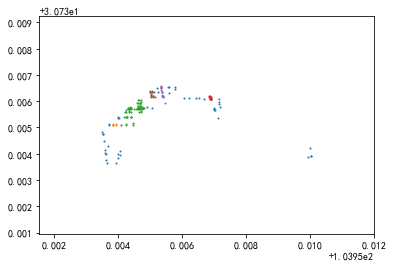

In [37]:
clustering_by_dbscan_and_kmeans2(df)